In [266]:
import pandas as pd
import numpy as np
from numpy import hstack
from numpy import array
from matplotlib import pyplot as plt
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Read the excel file and PreProcessing

In [592]:
# read the excel file
CL_Price_df = pd.read_excel('data/CL Pricing data.xlsx')
CL_Price_df.head()

,ObservationDate,Mo1,Mo2,Mo3,Mo4,Mo5,Mo6,Mo7,Mo8,Mo9,...,2/3,3/4,4/5,5/6,6/7,7/8,8/9,1/12,1/2_DoD,class
0,2011-01-03,91.55,92.43,93.14,93.72,94.13,94.45,94.65,94.77,94.84,...,-0.71,-0.58,-0.41,-0.32,-0.20,-0.12,-0.07,-3.28,NaN,Short
1,2011-01-04,89.38,90.42,91.32,92.07,92.63,93.06,93.33,93.51,93.62,...,-0.90,-0.75,-0.56,-0.43,-0.27,-0.18,-0.11,-4.37,-0.16,Short
2,2011-01-05,90.30,91.42,92.39,93.23,93.87,94.38,94.71,94.92,95.05,...,-0.97,-0.84,-0.64,-0.51,-0.33,-0.21,-0.13,-4.92,-0.08,Short
3,2011-01-06,88.38,89.75,90.90,91.84,92.54,93.09,93.46,93.72,93.92,...,-1.15,-0.94,-0.70,-0.55,-0.37,-0.26,-0.20,-5.92,-0.25,Short
4,2011-01-07,88.03,89.22,90.17,90.98,91.59,92.07,92.40,92.64,92.82,...,-0.95,-0.81,-0.61,-0.48,-0.33,-0.24,-0.18,-5.09,0.18,Long


In [593]:
# get the classes from dataframe and encode it to a unique.
class_list = CL_Price_df['class']
label_list = []
le = preprocessing.LabelEncoder()
le.fit(class_list)
le.classes_

array(['Long', 'Neutral', 'Short'], dtype=object)

In [594]:
# add the new column for label to dataframe
CL_Price_df['label'] = le.transform(class_list)
CL_Price_df.head()

,ObservationDate,Mo1,Mo2,Mo3,Mo4,Mo5,Mo6,Mo7,Mo8,Mo9,...,3/4,4/5,5/6,6/7,7/8,8/9,1/12,1/2_DoD,class,label
0,2011-01-03,91.55,92.43,93.14,93.72,94.13,94.45,94.65,94.77,94.84,...,-0.58,-0.41,-0.32,-0.20,-0.12,-0.07,-3.28,NaN,Short,2
1,2011-01-04,89.38,90.42,91.32,92.07,92.63,93.06,93.33,93.51,93.62,...,-0.75,-0.56,-0.43,-0.27,-0.18,-0.11,-4.37,-0.16,Short,2
2,2011-01-05,90.30,91.42,92.39,93.23,93.87,94.38,94.71,94.92,95.05,...,-0.84,-0.64,-0.51,-0.33,-0.21,-0.13,-4.92,-0.08,Short,2
3,2011-01-06,88.38,89.75,90.90,91.84,92.54,93.09,93.46,93.72,93.92,...,-0.94,-0.70,-0.55,-0.37,-0.26,-0.20,-5.92,-0.25,Short,2
4,2011-01-07,88.03,89.22,90.17,90.98,91.59,92.07,92.40,92.64,92.82,...,-0.81,-0.61,-0.48,-0.33,-0.24,-0.18,-5.09,0.18,Long,0


# Prepare the dataset

In [595]:
# get the input and output
input_x = CL_Price_df['1/2']
target_y = CL_Price_df['label']
input_x.shape, target_y.shape

((2604,), (2604,))

In [596]:
# split a sequence into samples
def split_sequences(sequenceX, sequenceY, n_steps):
    X, y = list(), list()
    for i in range(len(sequenceX)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequenceX)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequenceX[i:end_ix], sequenceY[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [622]:
#prepare the dataset
def prepare_dataset(x, y, n_steps):
    X, y = split_sequences(x, y, n_steps)
    #split the dataset into train and test dataset.
    X_train = X[:int(X.shape[0]*0.85)]
    X_test = X[int(X.shape[0]*0.85):]
    y_train = y[:int(X.shape[0]*0.85)]
    y_test = y[int(X.shape[0]*0.85):]
    return X_train, y_train, X_test, y_test

In [693]:
# choose a number of time steps
n_steps = 5
X_train, y_train, X_test, y_test = prepare_dataset(input_x, target_y, n_steps)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2209, 5), (2209,), (390, 5), (390,))

In [694]:
# dataset
column_label = []
for index in range(n_steps):
    if index == n_steps - 1:
        column_label.append('t')
    else:
        column_label.append('t-' + str(n_steps - 1 - index))
        
dataset = pd.DataFrame(X_train, columns=column_label)
dataset['Decision'] = y_train
dataset

,t-4,t-3,t-2,t-1,t,Decision
0,-0.88,-1.04,-1.12,-1.37,-1.19,2
1,-1.04,-1.12,-1.37,-1.19,-1.33,0
2,-1.12,-1.37,-1.19,-1.33,-1.25,0
3,-1.37,-1.19,-1.33,-1.25,-1.01,0
4,-1.19,-1.33,-1.25,-1.01,-0.90,2
...,...,...,...,...,...,...
2204,0.13,0.09,0.07,0.04,0.01,2
2205,0.09,0.07,0.04,0.01,-0.02,0
2206,0.07,0.04,0.01,-0.02,-0.01,2
2207,0.04,0.01,-0.02,-0.01,-0.08,0


# Decision Tree Classifier

In [695]:
#DecisionTree Classifier Function
def run_DecisionTreeClassifier(trainX, trainY, testX, testY, _max_leaf_nodes, _random_state):
    #DecisionTree classifier
    clf = DecisionTreeClassifier(max_leaf_nodes=_max_leaf_nodes, random_state=_random_state)
    clf.fit(trainX, trainY)
    predY = clf.predict(testX)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(testY, predY))
    return clf

Accuracy: 0.5230769230769231
Feature importance:
 t      0.421654
t-1    0.230873
t-3    0.224722
t-4    0.122751
t-2    0.000000
dtype: float64


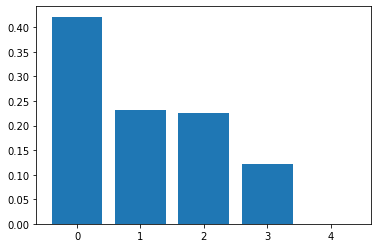

In [696]:
#DecisionTree classifier
_max_leaf_nodes  = 7
_random_state = 0
DT_clf = run_DecisionTreeClassifier(X_train, y_train, X_test, y_test, _max_leaf_nodes, _random_state)
# get importance
importance = pd.Series(DT_clf.feature_importances_,index = column_label).sort_values(ascending=False)
print("Feature importance:\n", importance)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

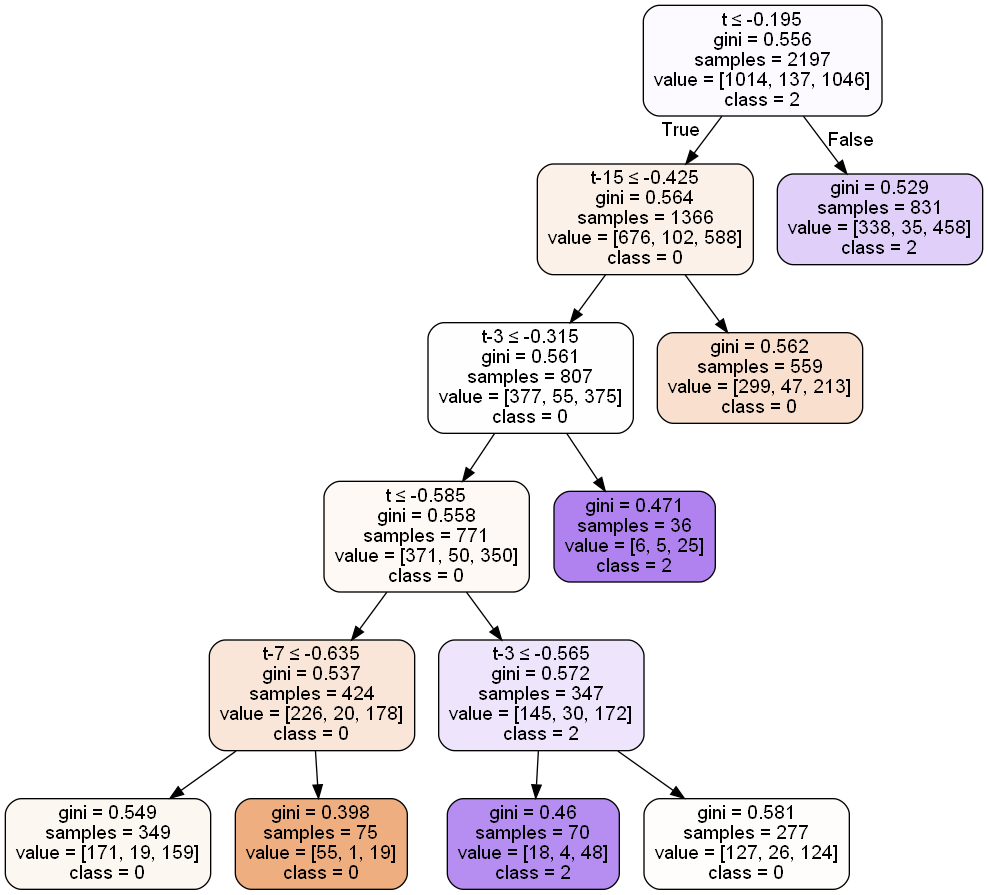

In [664]:
#decision tree graph
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydot
import os
os.environ['PATH'] = os.environ['PATH']+';' + r'X:\Program Files\Graphviz\bin'
dot_data = StringIO()
export_graphviz(DT_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = column_label,class_names=['0','1', '2'])
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Dtree.png')
Image(graph.create_png())

# RandomForest Classifier

In [643]:
def run_RandomForestClassifier(_max_depth, _n_estimators):
    #Create a Gaussian Classifier
    randomforest_clf=RandomForestClassifier(max_depth=_max_depth, n_estimators=_n_estimators)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    randomforest_clf.fit(X_train,y_train)

    y_pred=randomforest_clf.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    return randomforest_clf

Accuracy: 0.517948717948718
t      0.262619
t-3    0.207051
t-2    0.186017
t-4    0.172337
t-1    0.171976
dtype: float64


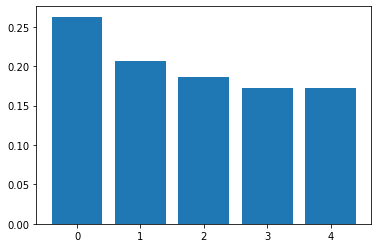

In [659]:
# Model Accuracy, how often is the classifier correct?
_max_depth = 4
_n_estimators = 70
# RandomForestClassifier
RF_clf = run_RandomForestClassifier(_max_depth, _n_estimators)
# feature importance
feature_imp = pd.Series(RF_clf.feature_importances_,index=column_label).sort_values(ascending=False)
print(feature_imp)
# plot feature importance
plt.bar([x for x in range(len(feature_imp))], feature_imp)
plt.show()

# LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)